Import necessary packages

In [12]:
# import necessary packages
import xarray as xr
from osgeo import gdal
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
from datetime import datetime


Classify burned pixels as burned area > 1% and save information in copy of Earth System Data Cube netcdf file 

In [7]:
# Load the data from the Earth System Data Cube into an xarray dataset^
ds_cube = xr.open_dataset('monthly_data_earth_cube.nc') # dataset with all variables

# Load the burnt area dataset
ds_ba = ds_cube.sel(time=slice('2014', '2015'))  # select the years of interest
ba_monthlyts = ds_ba['burnt_area']  # select the variable of interest
ba_monthlyts_m2 = ba_monthlyts * 10000  # Convert burnt_area unit from hectare to m^2

# Define the threshold for identifying burned pixels
threshold = 0.01  # 1% threshold for identifying burned pixels

# Calculate the total area of each grid cell
R = 6.371e6  # Earth's average radius in meters
dphi = np.deg2rad(0.25)
dlambda = np.deg2rad(0.25)
dlat = R * dphi * xr.ones_like(ds_ba['air_temperature_2m'].lon)
dlon = R * dlambda * xr.ones_like(ds_ba['air_temperature_2m'].lat) * np.cos(np.deg2rad(ds_ba['air_temperature_2m'].lat))
cell_area = dlat * dlon  # unit: m^2

# Calculate the sum of burnt area over the two years
ba_sum = ba_monthlyts_m2.sum(dim='time') 


# Calculate the percentage of burnt area for each grid cell
ba_percentage = (ba_sum * 100) / cell_area

# Identify burned pixels based on the threshold
burned_pixels = ba_percentage > threshold
unburned_pixels = ba_percentage <= threshold

# Add the "burned_pixels" variable to the original dataset
ds_cube['burned_pixel'] = burned_pixels

# Save the modified Dataset back to the .nc file
ds_cube.to_netcdf('monthly_data_cube_burned_pixels.nc')

# Print a message indicating the modified Dataset has been saved
print("Dataset with burned pixels added as a new variable has been saved to 'monthly_data_cube_burned_pixels.nc'.")


PermissionError: [Errno 13] Permission denied: 'c:\\Users\\annav\\OneDrive\\Desktop\\Remote_Sensing_Applications_GroupWork\\monthly_data_cube_burned_pixels.nc'

Preparing Pre-Wildfire Data Slices for Comparative Analysis: kNDVI, Air Temperature, Net Radiation, and GPP

In [8]:
# Prepare Slices for kndvi, airtemp, netradiation, gpp to use when comparing burned and control pixel 
ds_burned_pixels = xr.open_dataset('monthly_data_cube_burned_pixels.nc')

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012 (to avoid falsifying the values due to the seasonal cycle)
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# prepare air temp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
airtemp_data_2012 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2012-01-01', '2012-12-31'))
airtemp_data_2013 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the mean of air temperature for the year 2012 and 2013
airtemp_mean_2012 = airtemp_data_2012.mean(dim='time')
airtemp_mean_2013 = airtemp_data_2013.mean(dim='time')

# prepare net radiation slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
rn_data_2012 = ds_burned_pixels['net_radiation'].sel(time=slice('2012-01-01', '2012-12-31'))
rn_data_2013 = ds_burned_pixels['net_radiation'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the mean of net radiation for the year 2012 and 2013
rn_mean_2012 = rn_data_2012.mean(dim='time')
rn_mean_2013 = rn_data_2013.mean(dim='time')

# prepare gpp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
gpp_data_2012 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2012-01-01', '2012-12-31'))
gpp_data_2013 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of gpp for the year 2012 and 2013
gpp_sum_2012 = gpp_data_2012.sum(dim='time')
gpp_sum_2013 = gpp_data_2013.sum(dim='time')


Locating unburned control pixel for each burned pixel: Check for landcover type, kndvi, airtemp, net radiation, gpp

In [9]:
# Load the datasets
ds_burned_pixels = xr.open_dataset('monthly_data_cube_burned_pixels.nc')

ds_landcover_type = xr.open_dataset('ESA_LC.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values



# Define the function to find the closest unburned cell that fulfills conditions for landcove type, kndvi, gpp, net radiation and airtemp within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and not burned_pixels[lat_idx + di, lon_idx + dj] \
                        and ds_landcover_type['Band1'].sel(lat=lat_idx, lon=lon_idx, method='nearest').item() == \
                            ds_landcover_type['Band1'].sel(lat=lat_idx + di, lon=lon_idx + dj, method='nearest').item() \
                        and np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(gpp_sum_2012[lat_idx, lon_idx] - gpp_sum_2012[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(gpp_sum_2013[lat_idx, lon_idx] - gpp_sum_2013[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(rn_mean_2012[lat_idx, lon_idx] - rn_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(rn_mean_2013[lat_idx, lon_idx] - rn_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2012[lat_idx, lon_idx] - airtemp_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2013[lat_idx, lon_idx] - airtemp_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2:
                    
                    return lat_idx + di, lon_idx + dj
                    
        radius += 1
    return None, None


# Initialize lists to store pixel coordinates
burned_pixel_latitude = []
burned_pixel_longitude = []
control_pixel_latitude = []
control_pixel_longitude = []

# Initialize arrays to store control pixel information
control_pixel = np.zeros_like(burned_pixels, dtype=bool)
control_pixel_lat = np.zeros_like(burned_pixels, dtype=float)
control_pixel_lon = np.zeros_like(burned_pixels, dtype=float)

# Maximum radius to search for unburned control cells
max_radius = 5  

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_latitude.append(lat[lat_idx]) # add coordinates to the dataframe 
        burned_pixel_longitude.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            # Save info in dataframe (for csv file)
            control_pixel_latitude.append(lat[closest_unburned_lat])
            control_pixel_longitude.append(lon[closest_unburned_lon])
            # Mark the control pixel as True
            control_pixel[closest_unburned_lat, closest_unburned_lon] = True
            # Save the latitude and longitude of control pixel for the burned pixel
            control_pixel_lat[lat_idx, lon_idx] = lat[closest_unburned_lat]
            control_pixel_lon[lat_idx, lon_idx] = lon[closest_unburned_lon]

        else:
            control_pixel_latitude.append(np.nan)
            control_pixel_longitude.append(np.nan)

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_latitude,
    'burned_lon': burned_pixel_longitude,
    'control_lat': control_pixel_latitude,
    'control_lon': control_pixel_longitude
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('coordinates_burned_control.csv', index=False)

# Add control pixel information to the dataset
ds_burned_pixels['control_pixel'] = (('lat', 'lon'), control_pixel)
ds_burned_pixels['control_pixel_lat'] = (('lat', 'lon'), control_pixel_lat)
ds_burned_pixels['control_pixel_lon'] = (('lat', 'lon'), control_pixel_lon)

# Save the modified dataset
ds_burned_pixels.to_netcdf('monthly_data_cube_burned_control_pixels.nc')


Dropping Rows with Burned Pixels Without Appropriate Control Pixels


In [14]:
# Read the DataFrame with burned and control pixels
df_burned_control = pd.read_csv('coordinates_burned_control.csv')

# Drop rows where 'control_pixel_lat' or 'control_pixel_lon' are NaN (not considering burned pixels without respective control pixels for our analysis)
df_burned_control.dropna(subset=['control_lat', 'control_lon'], inplace=True)

# Save cleaned DataFrame to a new CSV file
df_burned_control.to_csv('coordinates_burned_control_without_nan.csv', index=False)


Determine Last Burn Time for Burned Pixels (time since burned area dropped below 1%)

In [21]:
# Read the DataFrame with burned and control pixels
df_burned_control_cleaned_lastburn = pd.read_csv('coordinates_burned_control_without_nan.csv')

# Read the Dataset with burnt area data
ds_ba = xr.open_dataset('monthly_data_cube_burned_control_pixels.nc')

# Select the years of interest
ds_ba = ds_ba.sel(time=slice('2014', '2015'))

# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_control_cleaned_lastburn.index:
    # Get coordinates of the burned pixel
    lon = df_burned_control_cleaned_lastburn.loc[i, 'burned_lon']
    lat = df_burned_control_cleaned_lastburn.loc[i, 'burned_lat']
    
    # Find the time since burned area percentage dropped below threshold
    threshold = 0.01  # 1% threshold for identifying burned pixels
    time_since_threshold = None
    for t in reversed(ds_ba.time.values):
        if ds_ba['burnt_area'].sel(time=t, lat=lat, lon=lon) > threshold:
            time_since_threshold = t
            break
    
    # Save the time in a new column in the DataFrame
    df_burned_control_cleaned_lastburn.at[i, 'last_burn'] = time_since_threshold

df_burned_control_cleaned_lastburn


,burned_lat,burned_lon,control_lat,control_lon,last_burn
0,50.125,-123.375,50.125,-122.625,2015-08-01
1,50.125,-117.625,50.125,-118.375,2014-10-01
2,50.125,-111.125,50.125,-111.375,2015-09-01
3,50.125,-105.125,50.125,-105.375,2015-05-01
4,50.125,-104.875,50.125,-104.625,2014-05-01
...,...,...,...,...,...
1576,67.375,-143.125,67.375,-142.875,2015-07-01
1577,67.375,-134.875,67.125,-135.125,2014-07-01
1578,67.375,-134.625,67.375,-134.375,2014-07-01
1579,68.125,-135.375,68.125,-135.125,2015-06-01


Compute KNDVI Sum Over 12 Months Post Last Burn for Burned & Control Pixels

In [22]:
# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_kndvi = xr.open_dataset('monthly_data_cube_burned_control_pixels.nc')

# Create a copy of the DataFrame
df_burned_control_cleaned_lastburn_kndvi = df_burned_control_cleaned_lastburn.copy()

# Create empty lists to store burned and control pixel kndvi values
burned_kndvi_values = []
control_kndvi_values = []

# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_control_cleaned_lastburn_kndvi.index:
    burned_lat = df_burned_control_cleaned_lastburn_kndvi.at[i, 'burned_lat']
    burned_lon = df_burned_control_cleaned_lastburn_kndvi.at[i, 'burned_lon']
    control_lat = df_burned_control_cleaned_lastburn_kndvi.at[i, 'control_lat']
    control_lon = df_burned_control_cleaned_lastburn_kndvi.at[i, 'control_lon']

    # Extract last burn time as datetime object
    last_burn_date = df_burned_control_cleaned_lastburn_kndvi.at[i, 'last_burn']

    # Add 12 months to the last burn time
    next_year_date = last_burn_date.replace(year=last_burn_date.year + 1)

    # Look up sum of burned and control pixel kndvi values over the 12 months after last burn
    burned_kndvi = ds_kndvi['kndvi'].sel(time=slice(last_burn_date, next_year_date), lat=burned_lat, lon=burned_lon).sum(dim='time').values
    control_kndvi = ds_kndvi['kndvi'].sel(time=slice(last_burn_date, next_year_date), lat=control_lat, lon=control_lon).sum(dim='time').values

    # Append severity values to the respective lists
    burned_kndvi_values.append(burned_kndvi)
    control_kndvi_values.append(control_kndvi)

# Add the lists of severity values to the DataFrame as new columns
df_burned_control_cleaned_lastburn_kndvi['burned_kndvi'] = burned_kndvi_values
df_burned_control_cleaned_lastburn_kndvi['control_kndvi'] = control_kndvi_values

df_burned_control_cleaned_lastburn_kndvi

,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573
1,50.125,-117.625,50.125,-118.375,2014-10-01,3.2552948,3.4985807
2,50.125,-111.125,50.125,-111.375,2015-09-01,1.3720381,1.2691953
3,50.125,-105.125,50.125,-105.375,2015-05-01,1.4570912,1.5974169
4,50.125,-104.875,50.125,-104.625,2014-05-01,1.3638697,1.3612678
...,...,...,...,...,...,...,...
1576,67.375,-143.125,67.375,-142.875,2015-07-01,2.622498,2.4642613
1577,67.375,-134.875,67.125,-135.125,2014-07-01,2.3339522,2.6225474
1578,67.375,-134.625,67.375,-134.375,2014-07-01,2.39625,2.5160825
1579,68.125,-135.375,68.125,-135.125,2015-06-01,0.0,0.0


Compute Severity Values Based on KNDVI Differences Between Burned and Control Pixels

In [23]:
df_burned_control_cleaned_lastburn_kndvi_severity = df_burned_control_cleaned_lastburn_kndvi.copy()

# Create empty lists to store burned and control pixel severities
severity_values = []

# Loop through all rows of the dataframe 
for i in df_burned_control_cleaned_lastburn_kndvi_severity.index:
    burned_kndvi = df_burned_control_cleaned_lastburn_kndvi_severity.at[i, 'burned_kndvi']
    control_kndvi = df_burned_control_cleaned_lastburn_kndvi_severity.at[i, 'control_kndvi']

    # Compute severity as difference between kndvi values of burned and control pixels
    severity = burned_kndvi - control_kndvi

    # Append severity values to the list
    severity_values.append(severity)

# Add the lists of severity values to the DataFrame as new columns
df_burned_control_cleaned_lastburn_kndvi_severity['severity_value'] = severity_values

df_burned_control_cleaned_lastburn_kndvi_severity


,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573,-0.648426
1,50.125,-117.625,50.125,-118.375,2014-10-01,3.2552948,3.4985807,-0.243286
2,50.125,-111.125,50.125,-111.375,2015-09-01,1.3720381,1.2691953,0.102843
3,50.125,-105.125,50.125,-105.375,2015-05-01,1.4570912,1.5974169,-0.140326
4,50.125,-104.875,50.125,-104.625,2014-05-01,1.3638697,1.3612678,0.002602
...,...,...,...,...,...,...,...,...
1576,67.375,-143.125,67.375,-142.875,2015-07-01,2.622498,2.4642613,0.158237
1577,67.375,-134.875,67.125,-135.125,2014-07-01,2.3339522,2.6225474,-0.288595
1578,67.375,-134.625,67.375,-134.375,2014-07-01,2.39625,2.5160825,-0.119833
1579,68.125,-135.375,68.125,-135.125,2015-06-01,0.0,0.0,0.000000


Drop all rows with severity values > 0

In [24]:
df_burned_control_cleaned_lastburn_kndvi_severity_cleaned = df_burned_control_cleaned_lastburn_kndvi_severity.copy()

# Drop rows where severity_value is positive (dropping all rows where kndvi of control pixel is lower than kndvi of burned pixel)
df_burned_control_cleaned_lastburn_kndvi_severity_cleaned = df_burned_control_cleaned_lastburn_kndvi_severity_cleaned.loc[df_burned_control_cleaned_lastburn_kndvi_severity_cleaned['severity_value'] <= 0]

Histogram of Severity Distribution

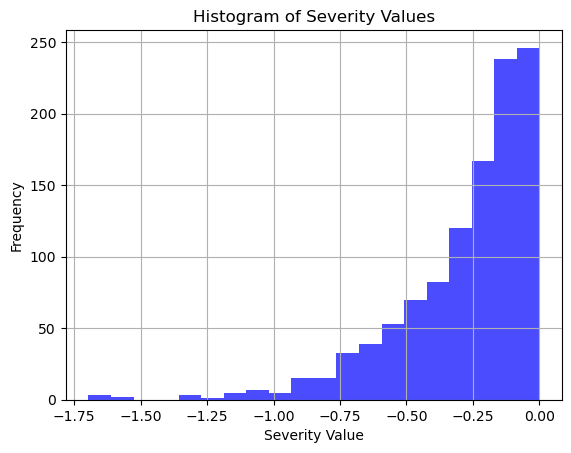

In [25]:
# Display the DataFrame after dropping rows
df_burned_control_cleaned_lastburn_kndvi_severity_cleaned

# Plot histogram for severity_value column
plt.hist(df_burned_control_cleaned_lastburn_kndvi_severity_cleaned['severity_value'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Severity Value')
plt.ylabel('Frequency')
plt.title('Histogram of Severity Values')
plt.grid(True)
plt.show()

Determine Severity Classes (Class_1: most severe, Class_20 least severe)

In [26]:
df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes = df_burned_control_cleaned_lastburn_kndvi_severity_cleaned.copy()

# Calculate quantiles to define severity classes
quantiles = df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes['severity_value'].quantile([i/20 for i in range(1, 20)])

# Function to assign severity class based on severity value (reversed order)
def assign_severity_class(severity_value):
    for i, quantile in enumerate(quantiles):
        if severity_value <= quantile:
            return f'Class_{i+1}'
    return f'Class_{len(quantiles) + 1}'  # For values above the last quantile

# Add a new column to the DataFrame indicating severity class
df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes['severity_class'] = df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes['severity_value'].apply(assign_severity_class)

# Print the first few rows to verify the new column
df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes


,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value,severity_class
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573,-0.648426,Class_2
1,50.125,-117.625,50.125,-118.375,2014-10-01,3.2552948,3.4985807,-0.243286,Class_9
3,50.125,-105.125,50.125,-105.375,2015-05-01,1.4570912,1.5974169,-0.140326,Class_13
5,50.125,-103.875,50.125,-103.625,2014-05-01,1.6484766,1.6839926,-0.035516,Class_19
6,50.125,-103.375,50.125,-103.625,2015-09-01,1.8659716,1.9131209,-0.047149,Class_18
...,...,...,...,...,...,...,...,...,...
1574,67.375,-144.875,67.375,-144.625,2015-07-01,2.6895885,2.6944537,-0.004865,Class_20
1575,67.375,-143.375,67.125,-142.375,2015-08-01,2.5938985,2.6351717,-0.041273,Class_18
1577,67.375,-134.875,67.125,-135.125,2014-07-01,2.3339522,2.6225474,-0.288595,Class_8
1578,67.375,-134.625,67.375,-134.375,2014-07-01,2.39625,2.5160825,-0.119833,Class_14


DataFrame Filtered for Highest Severity Class (Class 1)

In [32]:
df_burned_control_lastburn_kndvi_highest_severity = df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes[df_burned_control_cleaned_lastburn_kndvi_severity_cleaned_classes['severity_class'] == 'Class_1']

df_burned_control_lastburn_kndvi_highest_severity


,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value,severity_class
213,53.375,-125.125,53.375,-124.625,2015-05-01,2.5617387,3.6472173,-1.085479,Class_1
297,54.625,-106.375,54.875,-106.125,2015-08-01,2.7324939,3.51067,-0.778176,Class_1
318,54.875,-110.375,54.875,-110.875,2015-06-01,2.8247335,3.7604349,-0.935701,Class_1
353,55.125,-104.625,54.875,-104.625,2015-08-01,2.1671748,2.9806428,-0.813468,Class_1
374,55.375,-106.875,55.125,-107.125,2015-08-01,2.1221108,3.0346,-0.912489,Class_1
378,55.375,-105.625,54.375,-105.125,2015-07-01,1.7541063,3.4426155,-1.688509,Class_1
380,55.375,-104.625,54.625,-104.125,2015-07-01,2.8010397,3.6406214,-0.839582,Class_1
400,55.625,-109.625,55.625,-109.875,2015-08-01,3.1488242,4.205642,-1.056818,Class_1
401,55.625,-109.375,55.875,-109.125,2015-07-01,2.901399,3.7542498,-0.852851,Class_1
406,55.625,-107.125,55.625,-107.375,2015-07-01,2.142529,3.0530994,-0.910570,Class_1


Extracting Air Temperature and Precipitation Data from Earth System Data Cube for Burned and Control Pixels After Highest Severity Burns

In [51]:
# Make a copy of the dataframe to work with
df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip = df_burned_control_lastburn_kndvi_highest_severity.copy()

ds_burned_control = xr.open_dataset('monthly_data_cube_burned_control_pixels.nc')

# Create empty lists to store burned and control pixel airtemp and precipitation
burned_airtemp_values = []
control_airtemp_values = []

burned_precip_values = []
control_precip_values = []

# Loop through all rows of the dataframe (through all burned pixels with high fire severity)
for i in df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.index:
    # Get coordinates of burned and control pixels
    burned_lat = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.at[i, 'burned_lat']
    burned_lon = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.at[i, 'burned_lon']
    control_lat = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.at[i, 'control_lat']
    control_lon = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.at[i, 'control_lon']

    # Extract last burn time as datetime object
    last_burn_date = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.at[i, 'last_burn']

    # Sutract 1 year to the last burn time
    previous_year_date = last_burn_date.replace(year=last_burn_date.year - 1)

    # Add 2 years to the last burn time
    next_year_date = last_burn_date.replace(year=last_burn_date.year + 2)

    # Look up burned and control pixel air_temp values over the 37 months period
    burned_airtemp = ds_burned_control['air_temperature_2m'].sel(time=slice(previous_year_date, next_year_date), lat=burned_lat, lon=burned_lon).values
    control_airtemp = ds_burned_control['air_temperature_2m'].sel(time=slice(previous_year_date, next_year_date), lat=control_lat, lon=control_lon).values

    # Look up burned and control pixel precipitation values over the 37 months period
    burned_precipitation = ds_burned_control['precipitation_era5'].sel(time=slice(previous_year_date, next_year_date), lat=burned_lat, lon=burned_lon).values
    control_precipitation = ds_burned_control['precipitation_era5'].sel(time=slice(previous_year_date, next_year_date), lat=control_lat, lon=control_lon).values


    # Append airtemp and precipitation values to the respective lists
    burned_airtemp_values.append(burned_airtemp)
    control_airtemp_values.append(control_airtemp)

    burned_precip_values.append(burned_precipitation)
    control_precip_values.append(control_precipitation)

# Add the lists of severity values to the DataFrame as new columns
df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['burned_airtemp_values'] = burned_airtemp_values
df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['control_airtemp_values'] = control_airtemp_values

df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['burned_precip_values'] = burned_precip_values
df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['control_precip_values'] = control_precip_values

# Reset the index to start from 0 and drop the old index 
df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip.reset_index(drop=True, inplace=True)

# Display the DataFrame
df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip

,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value,severity_class,burned_airtemp_values,control_airtemp_values,burned_precip_values,control_precip_values
0,53.375,-125.125,53.375,-124.625,2015-05-01,2.5617387,3.6472173,-1.085479,Class_1,"[7.8960323, 11.180458, 14.732572, 15.692639, 1...","[8.507564, 11.849514, 15.440922, 16.051176, 10...","[2.5651112, 1.2028179, 1.353922, 0.5004091, 1....","[2.4405131, 1.45157, 1.1715254, 0.36368632, 1...."
1,54.625,-106.375,54.875,-106.125,2015-08-01,2.7324939,3.51067,-0.778176,Class_1,"[18.13596, 10.12133, 4.0716906, -12.337877, -1...","[18.479185, 10.183215, 3.8118553, -12.739711, ...","[1.5047585, 1.1533155, 0.79911464, 1.3916546, ...","[1.360252, 1.2985001, 0.79250795, 1.2696011, 0..."
2,54.875,-110.375,54.875,-110.875,2015-06-01,2.8247335,3.7604349,-0.935701,Class_1,"[13.7436495, 16.600786, 17.171507, 9.647337, 5...","[13.97499, 16.822989, 17.235863, 9.662583, 5.1...","[3.7417471, 3.7484605, 1.3343402, 1.5066962, 0...","[3.9320598, 4.3049555, 1.3720788, 1.6122429, 0..."
3,55.125,-104.625,54.875,-104.625,2015-08-01,2.1671748,2.9806428,-0.813468,Class_1,"[19.395847, 10.567538, 4.449489, -11.580086, -...","[18.645905, 10.056065, 3.816763, -12.418209, -...","[1.787322, 1.6620219, 1.1505964, 1.2706245, 0....","[1.9059482, 1.4794563, 1.0852778, 1.3659685, 0..."
4,55.375,-106.875,55.125,-107.125,2015-08-01,2.1221108,3.0346,-0.912489,Class_1,"[18.79466, 10.0057955, 4.050963, -12.761234, -...","[18.715712, 10.096033, 4.3222604, -12.308486, ...","[1.7819468, 1.1129712, 0.8548584, 0.8809079, 0...","[1.6680104, 1.0333873, 0.81189954, 0.92516303,..."
5,55.375,-105.625,54.375,-105.125,2015-07-01,1.7541063,3.4426155,-1.688509,Class_1,"[18.567448, 19.07021, 10.277865, 4.1878595, -1...","[16.9414, 17.746777, 10.078423, 3.8694754, -12...","[2.2205126, 1.5932686, 1.5475097, 0.7723785, 1...","[2.2174256, 1.3017659, 1.0425378, 0.77288496, ..."
6,55.375,-104.625,54.625,-104.125,2015-07-01,2.8010397,3.6406214,-0.839582,Class_1,"[18.602688, 19.302122, 10.408289, 4.1186743, -...","[17.73511, 18.310032, 10.011372, 3.346398, -12...","[1.514474, 1.8703178, 1.6794344, 1.0300134, 1....","[2.1679256, 2.0913296, 1.1674892, 1.1482141, 1..."
7,55.625,-109.625,55.625,-109.875,2015-08-01,3.1488242,4.205642,-1.056818,Class_1,"[17.533995, 9.284195, 4.392514, -11.839463, -1...","[17.512135, 9.221909, 4.450768, -11.795716, -1...","[1.8350885, 1.7787318, 0.83593863, 0.6496581, ...","[1.5679524, 1.8855135, 0.81295675, 0.68554187,..."
8,55.625,-109.375,55.875,-109.125,2015-07-01,2.901399,3.7542498,-0.852851,Class_1,"[17.697868, 17.70083, 9.469254, 4.4771843, -11...","[18.397856, 18.415573, 9.928522, 4.7073526, -1...","[2.666495, 2.0227525, 1.665616, 0.85171247, 0....","[2.5199533, 1.7432681, 1.7154474, 0.9600681, 0..."
9,55.625,-107.125,55.625,-107.375,2015-07-01,2.142529,3.0530994,-0.910570,Class_1,"[18.609108, 18.7576, 9.817893, 3.9433358, -12....","[18.55821, 18.718012, 9.821043, 4.056304, -12....","[2.336992, 2.0467288, 1.1767576, 0.89809763, 0...","[2.2246869, 1.9703519, 1.1431113, 0.9288119, 0..."


Generating Time Indices from t = -12 to t = 24 (last burn: t = 0)

In [43]:
# Generate 't' values from -12 to 24
t_values = list(range(-12, 25))

# Create a DataFrame with the 't' values
df_time_indices = pd.DataFrame({'t': t_values})

# Display the DataFrame
df_time_indices


,t
0,-12
1,-11
2,-10
3,-9
4,-8
5,-7
6,-6
7,-5
8,-4
9,-3


Computing Mean Air Temperature Difference between Burned and Control Pixels over Time

In [59]:
df_time_indices_airtemp = df_time_indices.copy()

# Create an empty list to store mean values for each index
mean_values_burned = []
mean_values_control = []

# Iterate over each index in the list
for i in range(len(df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['burned_airtemp_values'][0])):
    # Calculate the mean for the current index across all rows for burned_airtemp_values
    index_mean_burned = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['burned_airtemp_values'].apply(lambda x: x[i]).mean()
    # Append the mean value to the list for burned_airtemp_values
    mean_values_burned.append(index_mean_burned)

    # Calculate the mean for the current index across all rows for control_airtemp_values
    index_mean_control = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['control_airtemp_values'].apply(lambda x: x[i]).mean()
    # Append the mean value to the list for control_airtemp_values
    mean_values_control.append(index_mean_control)

# Create a new DataFrame with the mean values for burned_airtemp_values and control_airtemp_values
# df_time_indices_airtemp = pd.DataFrame({'mean_burned_airtemp': mean_values_burned, 'mean_control_airtemp': mean_values_control})
df_time_indices_airtemp['mean_burned_airtemp'] = mean_values_burned

df_time_indices_airtemp['mean_control_airtemp'] = mean_values_control

# Calculate the difference between mean_burned_airtemp and mean_control_airtemp
df_time_indices_airtemp['difference_airtemp'] = df_time_indices_airtemp['mean_burned_airtemp'] - df_time_indices_airtemp['mean_control_airtemp']

# Print the updated DataFrame
df_time_indices_airtemp

# Save the DataFrame as a CSV file
df_time_indices_airtemp.to_csv('df_time_indices_airtemp.csv', index=False)

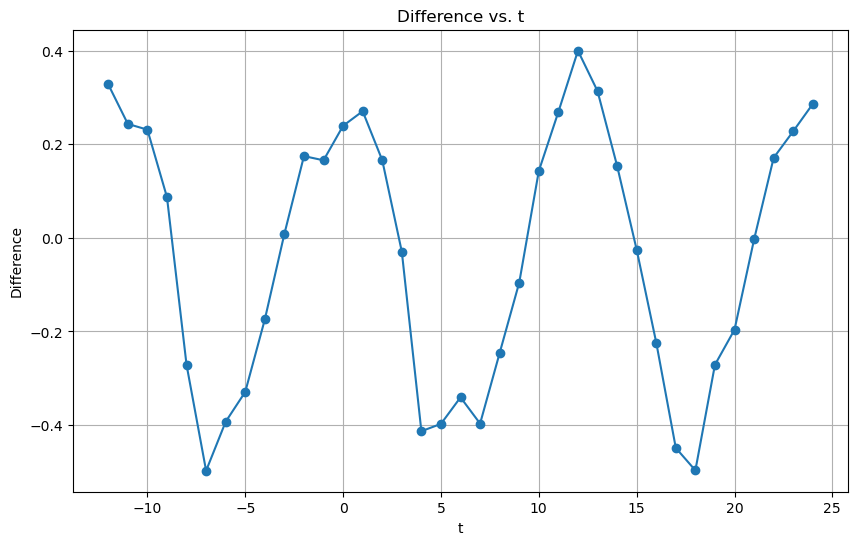

In [54]:
# Assuming df contains your dataframe with 't' and 'difference' columns
plt.figure(figsize=(10, 6))
plt.plot(df_time_indices_airtemp['t'], df_time_indices_airtemp['difference_airtemp'], marker='o', linestyle='-')
plt.title('Difference vs. t')
plt.xlabel('t')
plt.ylabel('Difference')
plt.grid(True)
plt.show()


Computing Mean Precipitation Difference between Burned and Control Pixels over Time

In [60]:
df_time_indices_precip = df_time_indices.copy()

# Create an empty list to store mean values for each index
mean_values_burned = []
mean_values_control = []

# Iterate over each index in the list
for i in range(len(df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['burned_precip_values'][0])):
    # Calculate the mean for the current index across all rows for burned_airtemp_values
    index_mean_burned = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['burned_precip_values'].apply(lambda x: x[i]).mean()
    # Append the mean value to the list for burned_airtemp_values
    mean_values_burned.append(index_mean_burned)

    # Calculate the mean for the current index across all rows for control_airtemp_values
    index_mean_control = df_burned_control_lastburn_kndvi_highest_severity_airtemp_precip['control_precip_values'].apply(lambda x: x[i]).mean()
    # Append the mean value to the list for control_airtemp_values
    mean_values_control.append(index_mean_control)

# Create a new DataFrame with the mean values for burned_airtemp_values and control_airtemp_values
df_time_indices_precip['mean_burned_precip'] = mean_values_burned

df_time_indices_precip['mean_control_precip'] = mean_values_control

# Calculate the difference between mean_burned_airtemp and mean_control_airtemp
df_time_indices_precip['difference_precip'] = df_time_indices_precip['mean_burned_precip'] - df_time_indices_precip['mean_control_precip']

# Print the updated DataFrame
df_time_indices_precip

# Save the DataFrame as a CSV file
df_time_indices_precip.to_csv('df_time_indices_precip.csv', index=False)



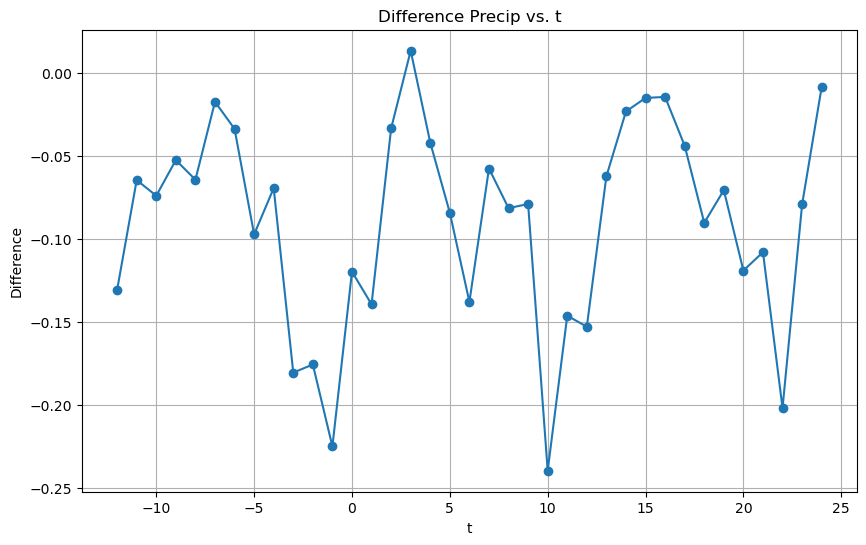

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df_time_indices_precip['t'], df_time_indices_precip['difference_precip'], marker='o', linestyle='-')
plt.title('Difference Precip vs. t')
plt.xlabel('t')
plt.ylabel('Difference')
plt.grid(True)
plt.show()
